In [ ]:
import logging as l
from pathlib import Path

import torch

from looped_experiments.all import *
from looped_experiments.eval import *
import looped_experiments.wandb_utils as wu

In [ ]:
eval_overrides = ["training.batch_size=256", "training.eval_steps=20", "task.n_points=20","model.n_loops=100"]
eval_overrides += ["model.n_loop_window=100"] # set loop window the same as n_loops to get predictions for all loops

In [ ]:
base = get_config()
# filter out runs that don't have a custom curriculum
filters = [lambda r: 'token_dec' in r.config['model']]
runs = wu.get_runs(base.wandb.project, wu.default_filters+filters)

In [ ]:
def looped_error(preds, ys):
    # get mean across points for each loop
    return torch.nanmean((preds - ys).square(), dim=-1).T

In [ ]:
# wu.refresh_models(runs.values())

In [ ]:
errs = {}
for k, v in runs.items():
    cfg = get_config(cfg_dict=v.config, overrides=eval_overrides)
    loc = Path("../"+v.config['out_dir'])
    loc = loc/'model_last.pt' if (loc/'model_last.pt').exists() else loc/'model_90000+train.pt'
    errs[k] = eval(cfg, loc, looped_error) 

In [ ]:
res = aggregate_metrics(errs, cfg.task.n_dims)

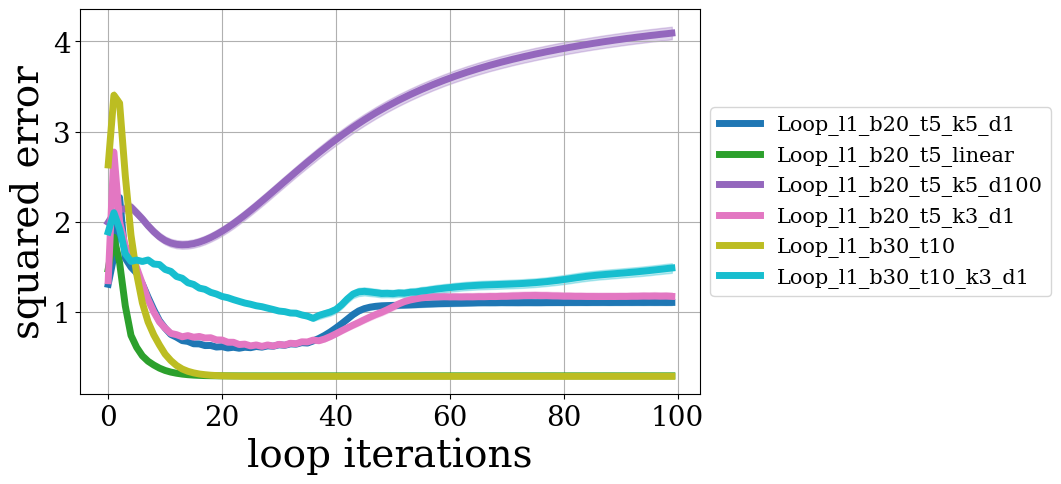

In [ ]:
ls, lw, fs = 28, 5, 15
ax = plot_results(res, cmap='tab10')
plt.grid()
plt.rc('font', family='serif')
# ax.set_ylim(-0.1, 1.25)
ax.set_xlabel("loop iterations", fontsize=ls)
y_label = ax.set_ylabel("squared error", fontsize=ls)
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fs)